In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.cuda as cuda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [2]:
features = np.load('dnnx_exp1.npy',allow_pickle=True)
labels = np.load('y_exp1.npy',allow_pickle=True)

In [3]:
features.shape

(239999, 24)

In [4]:
labels.shape

(239999,)

In [5]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [6]:
import torch.cuda as cuda
torch.cuda.is_available()

True

In [7]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(labels)
labels = integer_labels.reshape(-1)

In [8]:
features = torch.from_numpy(features)
labels = torch.from_numpy(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.125, random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1428, random_state=42)

In [11]:
train_set = TensorDataset(X_train,y_train)
val_set = TensorDataset(X_val,y_val)

In [12]:
batch_size = 2048
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=1)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=1)

In [13]:
 class ANNClassifier(nn.Module):
        def __init__(self,input_size,h1,h2,h3,h4,h5,output_size):
            super(ANNClassifier,self).__init__()
            self.fc1 = nn.Linear(input_size,h1)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.25)
            self.fc2 = nn.Linear(h1,h2)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.25)
            self.fc3 = nn.Linear(h2,h3)
            self.relu3 = nn.ReLU()
            self.dropout3 = nn.Dropout(0.25)
            self.fc4 = nn.Linear(h3,h4)
            self.relu4 = nn.ReLU()
            self.dropout4 = nn.Dropout(0.25)
            self.fc5 = nn.Linear(h4,h5)
            self.relu5 = nn.ReLU()
            self.dropout5 = nn.Dropout(0.25)
            self.fc6 = nn.Linear(h5,output_size)
            
        def forward(self,x):
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.relu2(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            x = self.relu3(x)
            x = self.dropout3(x)
            x = self.fc4(x)
            x = self.relu4(x)
            x = self.dropout4(x)
            x = self.fc5(x)
            x = self.relu5(x)
            x = self.dropout5(x)
            x = self.fc6(x)
            return x      
            

In [14]:
net = ANNClassifier(24,1024,512,256,128,64,3)
net = net.cuda()
criterion = nn.CrossEntropyLoss()
lr = 0.08
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

In [15]:
num_epochs = 250
train_loss=[]
valid_loss=[]
train_accuracy=[]
valid_accuracy=[]

In [16]:
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    total = 0
    net.train()
    
    for i, (features, labels) in enumerate(train_loader):
        features = Variable(features.float().cuda())
        labels = Variable(labels.long().cuda())
        
        optimizer.zero_grad()
        outputs = net(features)
        loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels)
        
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        iterations += 1
    
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct) / total)
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    net.eval()
    
    for i, (feat, lab) in enumerate(val_loader):
        feat = Variable(feat.float().cuda())
        lab = Variable(lab.long().cuda())
        
        out = net(feat)
        loss = F.nll_loss(F.log_softmax(out, dim=1), lab)
        
        val_loss += loss.item()
        _, predicted_val = torch.max(out, 1)
        correct_val += (predicted_val == lab).sum().item()
        total_val += lab.size(0)
    
    valid_loss.append(val_loss / len(val_loader))
    valid_accuracy.append((100 * correct_val) / total_val)
    
    print('epoch %d/%d, trloss: %.4f, tracc: %.4f, valloss: %.4f, valacc: %.4f' % (epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

epoch 1/250, trloss: 1.0555, tracc: 55.1316, valloss: 0.8592, valacc: 65.2894
epoch 2/250, trloss: 0.6305, tracc: 73.6338, valloss: 0.4803, valacc: 82.0095
epoch 3/250, trloss: 0.4854, tracc: 81.4984, valloss: 0.4121, valacc: 84.5805
epoch 4/250, trloss: 0.4301, tracc: 83.9521, valloss: 0.3645, valacc: 86.2245
epoch 5/250, trloss: 0.3899, tracc: 85.2892, valloss: 0.3333, valacc: 87.3116
epoch 6/250, trloss: 0.3669, tracc: 86.0886, valloss: 0.3164, valacc: 87.7985
epoch 7/250, trloss: 0.3523, tracc: 86.5458, valloss: 0.3050, valacc: 88.2253
epoch 8/250, trloss: 0.3431, tracc: 86.9091, valloss: 0.2961, valacc: 88.5921
epoch 9/250, trloss: 0.3340, tracc: 87.2319, valloss: 0.2901, valacc: 88.8255
epoch 10/250, trloss: 0.3288, tracc: 87.4441, valloss: 0.2855, valacc: 88.9589
epoch 11/250, trloss: 0.3220, tracc: 87.6930, valloss: 0.2806, valacc: 89.0823
epoch 12/250, trloss: 0.3172, tracc: 87.8563, valloss: 0.2769, valacc: 89.3357
epoch 13/250, trloss: 0.3142, tracc: 87.9563, valloss: 0.2743

In [ ]:
torch.save(net.state_dict(), 'annclassifier1.pth')

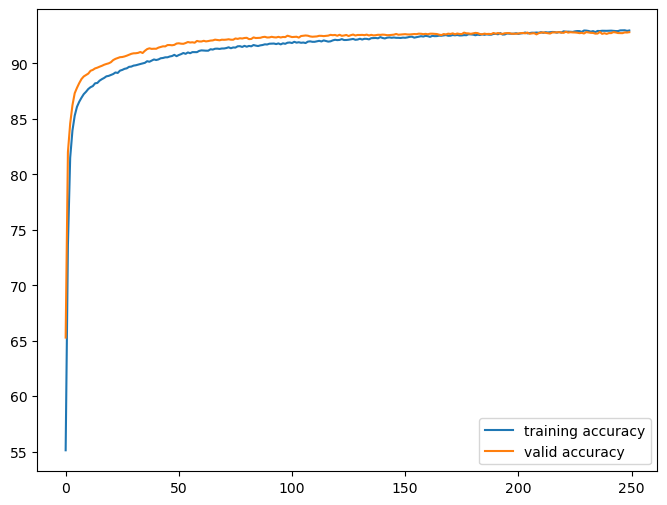

In [17]:
f = plt.figure(figsize=(8,6))
plt.plot(train_accuracy,label='training accuracy')
plt.plot(valid_accuracy,label='valid accuracy')
plt.legend()
plt.show()

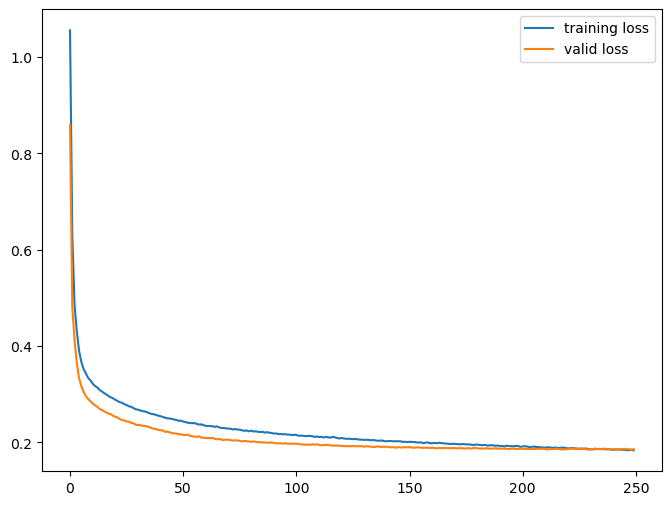

In [18]:
f = plt.figure(figsize=(8,6))
plt.plot(train_loss,label='training loss')
plt.plot(valid_loss,label='valid loss')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
net.eval()
X_test = X_test.float()
X_test = X_test.cuda()
y_pred = net(X_test)
y_pred = F.softmax(y_pred,dim=1)
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.argmax(y_pred,axis=1)
y_test = y_test.detach().cpu().numpy()
acc = accuracy_score(y_test, y_pred)
pr = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test,y_pred,average='macro')
cm = confusion_matrix(y_pred,y_test)

print('accuracy :',acc)
print('precision :',pr)
print('recall :',rec)
print('f1 score :',f1)




accuracy : 0.9288
precision : 0.9292306800283096
recall : 0.9287807923542237
f1 score : 0.9289131943585839


In [20]:
cm

array([[9489,  307,  123],
       [ 380, 9211,  692],
       [ 151,  483, 9164]], dtype=int64)